# Neural networks

In [286]:
from random import shuffle
from random import randint
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from operator import itemgetter
import time
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

import matplotlib.pyplot as plt
%matplotlib inline

import gc

## Load previously prepared data

In [325]:
df = pd.read_csv('data/laptop_train.csv')

In [326]:
df.head()

,company,product,typename,inches,cpu,ram(GB),gpu,opsys,weight(kg),resolution,screentype,touchscreen,cpu(GHz),memory_1_storage_gb,memory_1_type,memory_2_storage_gb,memory_2_type,log_price
0,Dell,Inspiron 3567,Notebook,15.6,Intel Core i3 7100U,6,Intel HD Graphics 620,Windows 10,2.30,1366x768,NaN,False,2.4,1000.0,HDD,0.0,NaN,6.129050
1,Lenovo,Legion Y520-15IKBN,Gaming,15.6,Intel Core i5 7300HQ,8,Nvidia GeForce GTX 1050,Windows 10,2.50,1920x1080,IPSPanel,False,2.5,256.0,SSD,0.0,NaN,6.720220
2,Dell,XPS 13,Ultrabook,13.3,Intel Core i7 8550U,8,Intel UHD Graphics 620,Windows 10,1.20,1920x1080,NaN,False,1.8,256.0,SSD,0.0,NaN,7.364547
3,Asus,ZenBook UX305CA-UBM1,Ultrabook,13.3,Intel Core M 6Y30,8,Intel HD Graphics 515,Windows 10,1.20,1920x1080,IPSPanel,False,0.9,512.0,SSD,0.0,NaN,6.591674
4,Dell,Inspiron 3567,Notebook,15.6,Intel Core i3 6006U,4,AMD Radeon R5 M430,Linux,2.25,1366x768,NaN,False,2.0,1000.0,HDD,0.0,NaN,6.143370


In [327]:
df.columns

Index(['company', 'product', 'typename', 'inches', 'cpu', 'ram(GB)', 'gpu',
       'opsys', 'weight(kg)', 'resolution', 'screentype', 'touchscreen',
       'cpu(GHz)', 'memory_1_storage_gb', 'memory_1_type',
       'memory_2_storage_gb', 'memory_2_type', 'log_price'],
      dtype='object')

In [328]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1132 entries, 0 to 1131
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   company              1132 non-null   object 
 1   product              1132 non-null   object 
 2   typename             1132 non-null   object 
 3   inches               1132 non-null   float64
 4   cpu                  1132 non-null   object 
 5   ram(GB)              1132 non-null   int64  
 6   gpu                  1132 non-null   object 
 7   opsys                1132 non-null   object 
 8   weight(kg)           1132 non-null   float64
 9   resolution           1132 non-null   object 
 10  screentype           301 non-null    object 
 11  touchscreen          1132 non-null   bool   
 12  cpu(GHz)             1132 non-null   float64
 13  memory_1_storage_gb  1132 non-null   float64
 14  memory_1_type        1132 non-null   object 
 15  memory_2_storage_gb  1132 non-null   f

In [329]:
target = "log_price"
numericFeatures = ["inches", "ram(GB)", "weight(kg)", "cpu(GHz)", "memory_1_storage_gb", "memory_2_storage_gb"]
catFeatures = ["company", "product", "typename", "cpu", "gpu", "opsys", "resolution", "screentype", "touchscreen", "memory_1_type", "memory_2_type"]

In [330]:
# en = LabelEncoder()
# for cols in catFeatures:
#     df[cols] = en.fit_transform(df[cols])
# print('Dataframe encoded by Label encoding dimension : ', df.shape)

In [331]:
df

,company,product,typename,inches,cpu,ram(GB),gpu,opsys,weight(kg),resolution,screentype,touchscreen,cpu(GHz),memory_1_storage_gb,memory_1_type,memory_2_storage_gb,memory_2_type,log_price
0,Dell,Inspiron 3567,Notebook,15.6,Intel Core i3 7100U,6,Intel HD Graphics 620,Windows 10,2.30,1366x768,NaN,False,2.4,1000.0,HDD,0.0,NaN,6.129050
1,Lenovo,Legion Y520-15IKBN,Gaming,15.6,Intel Core i5 7300HQ,8,Nvidia GeForce GTX 1050,Windows 10,2.50,1920x1080,IPSPanel,False,2.5,256.0,SSD,0.0,NaN,6.720220
2,Dell,XPS 13,Ultrabook,13.3,Intel Core i7 8550U,8,Intel UHD Graphics 620,Windows 10,1.20,1920x1080,NaN,False,1.8,256.0,SSD,0.0,NaN,7.364547
3,Asus,ZenBook UX305CA-UBM1,Ultrabook,13.3,Intel Core M 6Y30,8,Intel HD Graphics 515,Windows 10,1.20,1920x1080,IPSPanel,False,0.9,512.0,SSD,0.0,NaN,6.591674
4,Dell,Inspiron 3567,Notebook,15.6,Intel Core i3 6006U,4,AMD Radeon R5 M430,Linux,2.25,1366x768,NaN,False,2.0,1000.0,HDD,0.0,NaN,6.143370
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1127,HP,EliteBook 840,Notebook,14.0,Intel Core i5 6200U,4,Intel HD Graphics 520,Windows 10,1.54,1920x1080,NaN,False,2.3,500.0,HDD,0.0,NaN,6.907755
1128,Acer,Aspire F5-573G,Notebook,15.6,Intel Core i5 7200U,8,Nvidia GeForce GTX 950M,Windows 10,2.40,1920x1080,NaN,False,2.5,256.0,SSD,1000.0,HDD,6.683361
1129,HP,15-bs078cl (i7-7500U/8GB/2TB/W10),Notebook,15.6,Intel Core i7 7500U,8,Intel HD Graphics 620,Windows 10,2.04,1366x768,NaN,False,2.7,2000.0,HDD,0.0,NaN,6.444131
1130,HP,Pavilion 15-AW003nv,Notebook,15.6,AMD A9-Series 9410,6,AMD Radeon R7 M440,Windows 10,2.04,1920x1080,NaN,False,2.9,1000.0,Hybrid,0.0,NaN,6.309900


In [332]:
# One hot encoding
dummLev = pd.get_dummies(df[catFeatures], drop_first=True)

# Połączenie zmiennych numerycznych, kategorycznych w postaci on hot encoding oraz targetu
df = pd.concat([df[numericFeatures], dummLev, df[[target]]], axis=1)

df[numericFeatures] = df[numericFeatures].apply(lambda x: (x-x.mean())/x.std())

In [333]:
df[numericFeatures] = df[numericFeatures].apply(lambda x: (x-x.mean())/x.std())

In [334]:
features = df.columns.tolist()
features.remove(target)

In [335]:
df

,inches,ram(GB),weight(kg),cpu(GHz),memory_1_storage_gb,memory_2_storage_gb,touchscreen,company_Apple,company_Asus,company_Chuwi,...,resolution_2560x1600,resolution_3200x1800,resolution_3840x2160,screentype_IPSPanelRetinaDisplay,memory_1_type_HDD,memory_1_type_Hybrid,memory_1_type_SSD,memory_2_type_Hybrid,memory_2_type_SSD,log_price
0,0.391592,-0.474786,0.379054,0.190372,1.610548,-0.427352,False,0,0,0,...,0,0,0,0,1,0,0,0,0,6.129050
1,0.391592,-0.053251,0.688120,0.391249,-0.541155,-0.427352,False,0,0,0,...,0,0,0,0,0,0,1,0,0,6.720220
2,-1.271621,-0.053251,-1.320809,-1.014891,-0.541155,-0.427352,False,0,0,0,...,0,0,0,0,0,0,1,0,0,7.364547
3,-1.271621,-0.053251,-1.320809,-2.822787,0.199216,-0.427352,False,0,1,0,...,0,0,0,0,0,0,1,0,0,6.591674
4,0.391592,-0.896322,0.301787,-0.613137,1.610548,-0.427352,False,0,0,0,...,0,0,0,0,1,0,0,0,0,6.143370
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1127,-0.765426,-0.896322,-0.795397,-0.010505,0.164511,-0.427352,False,0,0,0,...,0,0,0,0,1,0,0,0,0,6.907755
1128,0.391592,-0.053251,0.533587,0.391249,-0.541155,2.027998,False,0,0,0,...,0,0,0,0,0,0,1,0,0,6.683361
1129,0.391592,-0.053251,-0.022732,0.793004,4.502623,-0.427352,False,0,0,0,...,0,0,0,0,1,0,0,0,0,6.444131
1130,0.391592,-0.474786,-0.022732,1.194758,1.610548,-0.427352,False,0,0,0,...,0,0,0,0,0,1,0,0,0,6.309900


In [336]:
#X=df.drop('log_price', axis = 1).values
#y=df['log_price'].values

In [ ]:
features = df.columns.tolist()
features.remove(target)

# Neural network

In [411]:
import pandas as pd
import numpy as np
import os
import shutil
import pickle as pk
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from keras import models
from keras import layers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

from sklearn import metrics

In [412]:
x = df.drop('log_price', axis=1)
y = df['log_price']

In [413]:
train_ratio = 0.70
validation_ratio = 0.15
test_ratio = 0.15

# Generate TrainX and TrainY
trainX, testX, trainY, testY = train_test_split(x, y, test_size= 1 - train_ratio)
# Genearate ValX, TestX, ValY and TestY
valX, testX, valY, testY = train_test_split(testX, testY, test_size=test_ratio/(test_ratio + validation_ratio))

In [414]:
print(trainX.shape)
print(valX.shape)
print(testX.shape)

(792, 780)
(170, 780)
(170, 780)


In [415]:
sc=StandardScaler()

scaler = sc.fit(trainX)

trainX_scaled = scaler.transform(trainX)
valX_scaled = scaler.transform(valX)
testX_scaled = scaler.transform(testX)

In [416]:
checkpoint_no = 'ckpt_1_ANN'
model_name = 'House_ANN_2FC_F64_64_epoch_120'

In [417]:
input_shape = trainX.shape[1]

n_batch_size = 128

n_steps_per_epoch = int(trainX.shape[0] / n_batch_size)
n_validation_steps = int(valX.shape[0] / n_batch_size)
n_test_steps = int(testX.shape[0] / n_batch_size)

n_epochs = 120


print('Input Shape: ' + str(input_shape))
print('Batch Size: ' + str(n_batch_size))
print()
print('Steps per Epoch: ' + str(n_steps_per_epoch))
print()
print('Validation Steps: ' + str(n_validation_steps))
print('Test Steps: ' + str(n_test_steps))
print()
print('Number of Epochs: ' + str(n_epochs))

Input Shape: 780
Batch Size: 128

Steps per Epoch: 6

Validation Steps: 1
Test Steps: 1

Number of Epochs: 120


In [418]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(input_shape,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1))

In [419]:
model.summary()

Model: "sequential_77"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_219 (Dense)           (None, 64)                49984     
                                                                 
 dense_220 (Dense)           (None, 64)                4160      
                                                                 
 dense_221 (Dense)           (None, 1)                 65        
                                                                 
Total params: 54,209
Trainable params: 54,209
Non-trainable params: 0
_________________________________________________________________


In [420]:
model.compile(loss='mse',
              optimizer='rmsprop',
              metrics=['mae'])

In [421]:
checkpoint_dir = './'+ checkpoint_no
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

In [422]:
keras_callbacks = [ModelCheckpoint(filepath = checkpoint_dir + '/' + model_name, 
                                   monitor='val_loss', save_best_only=True, mode='auto')]

In [423]:
history = model.fit(trainX_scaled,
                    trainY,
                    steps_per_epoch=n_steps_per_epoch,
                    epochs=n_epochs,
                    batch_size=n_batch_size,
                    validation_data=(valX_scaled, valY),
                    validation_steps=n_validation_steps,
                    callbacks=[keras_callbacks])

Epoch 1/120
6/6 [==============================] - 3s 288ms/step - loss: 45.5109 - mae: 6.6523 - val_loss: 32.1655 - val_mae: 5.6180
Epoch 2/120
6/6 [==============================] - 1s 144ms/step - loss: 22.6067 - mae: 4.6295 - val_loss: 20.1633 - val_mae: 4.3949
Epoch 3/120
6/6 [==============================] - 1s 218ms/step - loss: 11.8551 - mae: 3.1891 - val_loss: 11.4269 - val_mae: 3.2215
Epoch 4/120
6/6 [==============================] - 1s 136ms/step - loss: 5.5592 - mae: 2.0551 - val_loss: 5.8503 - val_mae: 2.1879
Epoch 5/120
6/6 [==============================] - 1s 129ms/step - loss: 2.4549 - mae: 1.2898 - val_loss: 3.0774 - val_mae: 1.4632
Epoch 6/120
6/6 [==============================] - 1s 137ms/step - loss: 1.2786 - mae: 0.8764 - val_loss: 2.1536 - val_mae: 1.1600
Epoch 7/120
6/6 [==============================] - 1s 142ms/step - loss: 0.8443 - mae: 0.6923 - val_loss: 1.5406 - val_mae: 0.9505
Epoch 8/120
6/6 [==============================] - 1s 135ms/step - loss: 0.48

In [424]:
hist_df = pd.DataFrame(history.history)
hist_df['epoch'] = hist_df.index + 1
cols = list(hist_df.columns)
cols = [cols[-1]] + cols[:-1]
hist_df = hist_df[cols]
hist_df.to_csv(checkpoint_no + '/' + 'history_df_' + model_name + '.csv')
hist_df.head()

,epoch,loss,mae,val_loss,val_mae
0,1,45.510929,6.652294,32.165478,5.617958
1,2,22.606705,4.629506,20.163258,4.394872
2,3,11.855143,3.189123,11.426888,3.221524
3,4,5.559226,2.055126,5.850312,2.187925
4,5,2.454854,1.289756,3.077375,1.463246


In [425]:
values_of_best_model = hist_df[hist_df.val_loss == hist_df.val_loss.min()]
values_of_best_model

,epoch,loss,mae,val_loss,val_mae
103,104,0.044996,0.163058,0.688966,0.582573


In [426]:
pk.dump(scaler, open(checkpoint_no + '/' + 'scaler.pkl', 'wb'))

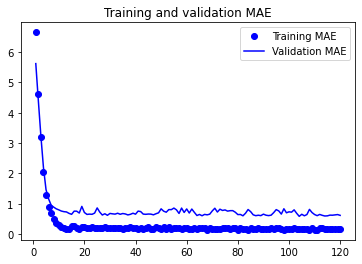

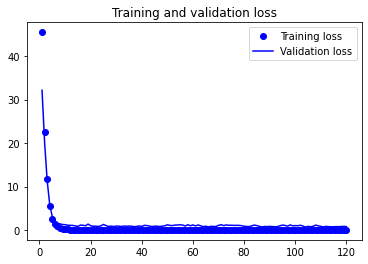

In [427]:
mae = history.history['mae']
val_mae = history.history['val_mae']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(mae) + 1)

plt.plot(epochs, mae, 'bo', label='Training MAE')
plt.plot(epochs, val_mae, 'b', label='Validation MAE')
plt.title('Training and validation MAE')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## K-fold cross validation

In [428]:
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',
                           input_shape=(input_shape,)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(loss='mse', optimizer='rmsprop', metrics=['mae'])
    return model


In [429]:
k = 5
num_val_samples = len(trainX) // k

In [430]:
all_scores = []
for i in range(k):
    print('Processing Fold', i)
    val_data = trainX_scaled[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = trainY[i * num_val_samples: (i + 1) * num_val_samples]

    partial_train_data = np.concatenate(
        [trainX_scaled[:i * num_val_samples],
         trainX_scaled[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [trainY[:i * num_val_samples],
         trainY[(i + 1) * num_val_samples:]],
        axis=0)

    model = build_model()
    model.fit(partial_train_data, partial_train_targets,
              epochs=n_epochs, batch_size=n_batch_size, verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)
    print('MAE: ' + str(val_mae))
    print('----------------------')

Processing Fold 0
MAE: 1.8061044216156006
----------------------
Processing Fold 1
MAE: 1.2503843307495117
----------------------
Processing Fold 2
MAE: 1.4653699398040771
----------------------
Processing Fold 3
MAE: 1.721246600151062
----------------------
Processing Fold 4
MAE: 1.4043433666229248
----------------------


In [431]:
for i, val in enumerate(all_scores):
    print('Fold ' + str(i) +': ' + 'MAE of', val)

Fold 0: MAE of 1.8061044216156006
Fold 1: MAE of 1.2503843307495117
Fold 2: MAE of 1.4653699398040771
Fold 3: MAE of 1.721246600151062
Fold 4: MAE of 1.4043433666229248


In [432]:
print('Mean MAE of all folds: ' + str(np.mean(all_scores)))

Mean MAE of all folds: 1.5294897317886353


In [433]:
all_mae_histories = []
for i in range(k):
    print('Processing Fold', i)
    val_data = trainX_scaled[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = trainY[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate(
        [trainX_scaled[:i * num_val_samples],
         trainX_scaled[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [trainY[:i * num_val_samples],
         trainY[(i + 1) * num_val_samples:]],
        axis=0)

    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=n_epochs, batch_size=n_batch_size, verbose=0)
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)

Processing Fold 0
Processing Fold 1
Processing Fold 2
Processing Fold 3
Processing Fold 4


In [434]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(n_epochs)]

len(average_mae_history)

120

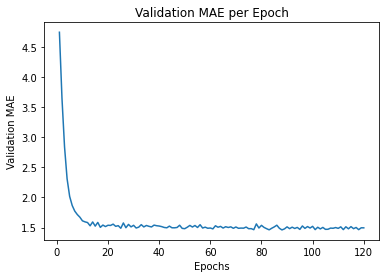

In [435]:
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.title('Validation MAE per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [436]:
def smooth_curve(points, factor=0.9):
      '''
      Function for smoothing data points

      Args:
          points (float64): Array of floats to be smoothed, numpy array of floats

      Returns:
          Smoothed data points
      '''  
      smoothed_points = []
      for point in points:
        if smoothed_points:
          previous = smoothed_points[-1]
          smoothed_points.append(previous * factor + point * (1 - factor))
        else:
          smoothed_points.append(point)
      return smoothed_points

In [437]:
n_first_observations_to_exclude = 30

smooth_mae_history = smooth_curve(average_mae_history[n_first_observations_to_exclude:])

smooth_mae_history = pd.DataFrame(smooth_mae_history)
smooth_mae_history = smooth_mae_history.set_index(smooth_mae_history.index + n_first_observations_to_exclude)
smooth_mae_history.head()

,0
30,1.491659
31,1.493045
32,1.498485
33,1.499614
34,1.503016


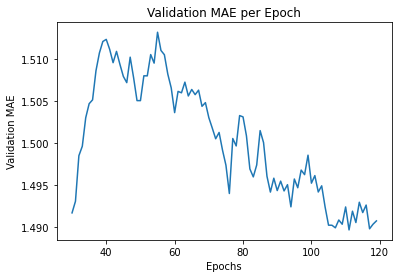

In [438]:
plt.plot(smooth_mae_history)
plt.title('Validation MAE per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [439]:
# Loading the automatically saved model
model_reloaded = load_model(checkpoint_no + '/' + model_name)

# Saving the best model in the correct path and format
root_directory = os.getcwd()
checkpoint_dir = os.path.join(root_directory, checkpoint_no)
model_name_temp = os.path.join(checkpoint_dir, model_name + '.h5')
model_reloaded.save(model_name_temp)

# Deletion of the automatically created folder under Model Checkpoint File.
folder_name_temp = os.path.join(checkpoint_dir, model_name)
shutil.rmtree(folder_name_temp, ignore_errors=True)

In [440]:
best_model = load_model(model_name_temp)

In [441]:
test_loss, test_mae = best_model.evaluate(testX_scaled,
                                          testY,
                                          steps=n_test_steps)
print()
print('Test MAE:', test_mae)

1/1 [==============================] - 0s 205ms/step - loss: 0.8103 - mae: 0.6800

Test MAE: 0.6800051927566528


In [475]:
X = scaler.transform(df[features])
#Y = scaler.transform(df[target])

In [476]:
pred = model.predict(X)

36/36 [==============================] - 0s 2ms/step


In [485]:
df_Y = pd.DataFrame(Y)
df_pred = pd.DataFrame(model.predict(X))

df_Y.reset_index(drop=True, inplace=True)
df_pred.reset_index(drop=True, inplace=True)

df_results = pd.concat([df_Y, df_pred], axis=1)
df_results.columns = ['Actual', 'Predicted']

df_results

36/36 [==============================] - 0s 2ms/step


,Actual,Predicted
0,6.129050,6.134566
1,6.720220,6.707363
2,7.364547,7.385225
3,6.591674,6.657373
4,6.143370,6.115696
...,...,...
1127,6.907755,6.954369
1128,6.683361,6.997562
1129,6.444131,6.768174
1130,6.309900,6.313198


In [479]:
metrics.r2_score(Y, pred)

-1.982503674186479

In [499]:
print('Mean Absolute Error:', metrics.mean_absolute_error(Y, pred))
print('Mean Squared Error:', metrics.mean_squared_error(Y, pred))
print('Root Mean Squared Error:', metrics.mean_squared_error(Y, pred, squared=False))
print('Mean Absolute Percentage Error:', metrics.mean_absolute_percentage_error(Y, pred))

Mean Absolute Error: 0.5561407484954031
Mean Squared Error: 1.1607912700419176
Root Mean Squared Error: 1.0774002367003257
Mean Absolute Percentage Error: 0.08149729556703406


## Save the model

Let's save the model. I will later compare the performance of different models on the testing dataset

In [239]:
import pickle

In [504]:
pickle.dump(best_model, open('neural_network.sav', 'wb'))

# BRUDNOPIS

In [507]:
df = pd.read_csv('data/laptop_train.csv')

In [508]:
# One hot encoding
dummLev = pd.get_dummies(df[catFeatures], drop_first=True)

# Połączenie zmiennych numerycznych, kategorycznych w postaci on hot encoding oraz targetu
df = pd.concat([df[numericFeatures], dummLev, df[[target]]], axis=1)

df[numericFeatures] = df[numericFeatures].apply(lambda x: (x-x.mean())/x.std())

In [515]:
df_sc = scaler.transform(df[features])

In [516]:
pred = best_model.predict(df_sc)

36/36 [==============================] - 0s 2ms/step


In [517]:
pred

array([[5.9421787],
       [6.791689 ],
       [7.171391 ],
       ...,
       [6.011772 ],
       [6.1567183],
       [6.7748027]], dtype=float32)

In [518]:
df[target]

0       6.129050
1       6.720220
2       7.364547
3       6.591674
4       6.143370
          ...   
1127    6.907755
1128    6.683361
1129    6.444131
1130    6.309900
1131    6.746013
Name: log_price, Length: 1132, dtype: float64

In [519]:
metrics.r2_score(df[target], pred)

0.6325403851738128

In [529]:
df = pd.read_csv('data/laptop_test.csv')

target = "log_price"
numericFeatures = ["inches", "ram(GB)", "weight(kg)", "cpu(GHz)", "memory_1_storage_gb", "memory_2_storage_gb"]
catFeatures = ["company", "product", "typename", "cpu", "gpu", "opsys", "resolution", "screentype", "touchscreen", "memory_1_type", "memory_2_type"]

features = df.columns.tolist()
features.remove(target)

en = LabelEncoder()
for cols in catFeatures:
    df[cols] = en.fit_transform(df[cols])
print('Dataframe encoded by Label encoding dimension : ', df.shape)

Dataframe encoded by Label encoding dimension :  (131, 18)


In [530]:
loaded_model = pickle.load(open('xgboost.sav', 'rb'))
result = loaded_model.score(df[features], df[target])
print(result)

[02:20:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
-0.19124645548577024
